In [ ]:
# This was made following this tutorial: https://github.com/vijayaiitk/NLP-text-classification-model/blob/main/NLP%20text%20classification%20model%20Github.ipynb

In [1]:
import pandas as pd
import numpy as np
#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
#for word embedding
import gensim
from gensim.models import Word2Vec

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/marcosviniciuspereiramarques/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/marcosviniciuspereiramarques/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/marcosviniciuspereiramarques/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
df_train= pd.read_csv('bases/class.csv')
# df_test=pd.read_csv('bases/20230825_Pedidos_csv_2023.csv', encoding='UTF-16', delimiter=";")

In [4]:
x=df_train['Veredito'].value_counts()
print(x)
# sns.barplot(x.index,x)

Veredito
1    634
0    633
Name: count, dtype: int64


In [5]:
df_train.isna().sum()

Pedidos e respostas      0
Órgão                  969
Ano                    969
Assunto                969
Decisão                969
Veredito                 0
dtype: int64

In [6]:
# WORD-COUNT
df_train['word_count'] = df_train['Pedidos e respostas'].apply(lambda x: len(str(x).split()))
print(df_train[df_train['Veredito']==1]['word_count'].mean()) #Disaster tweets
print(df_train[df_train['Veredito']==0]['word_count'].mean()) #Non-Disaster tweets

302.9842271293375
74.88625592417061


In [7]:
import matplotlib.pyplot as plt

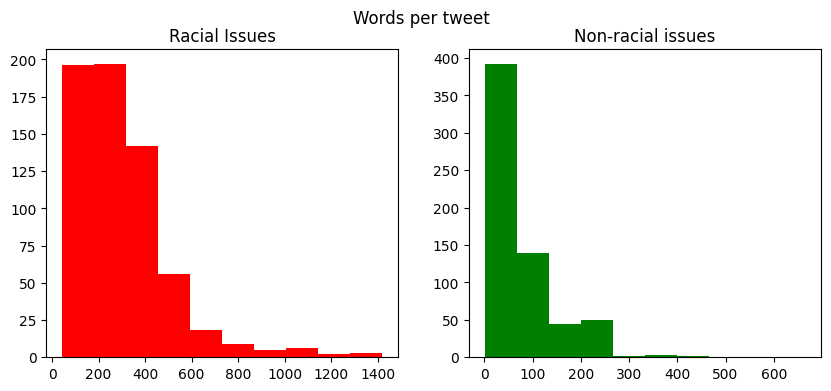

In [8]:
# PLOTTING WORD-COUNT
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
train_words=df_train[df_train['Veredito']==1]['word_count']
ax1.hist(train_words,color='red')
ax1.set_title('Racial Issues')
train_words=df_train[df_train['Veredito']==0]['word_count']
ax2.hist(train_words,color='green')
ax2.set_title('Non-racial issues')
fig.suptitle('Words per tweet')
plt.show()

In [9]:
# CHARACTER-COUNT
df_train['char_count'] = df_train['Pedidos e respostas'].apply(lambda x: len(str(x)))
print(df_train[df_train['Veredito']==1]['char_count'].mean()) #Racial issues tweets
print(df_train[df_train['Veredito']==0]['char_count'].mean()) #Non-racial issues tweets

2059.454258675079
494.64296998420224


In [10]:
#convert to lowercase, strip and remove punctuations
def preprocess(text):
    text = text.lower() 
    text=text.strip()  
    text=re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    return text

 
# STOPWORD REMOVAL
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('portuguese')]
    return ' '.join(a)
#LEMMATIZATION
# Initialize the lemmatizer
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

In [11]:
def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))
df_train['clean_text'] = df_train['Pedidos e respostas'].apply(lambda x: finalpreprocess(x))
df_train.head()

,Pedidos e respostas,Órgão,Ano,Assunto,Decisão,Veredito,word_count,char_count,clean_text
0,No concurso 54/16 desta instituição foram conv...,UNIFESSPA – Universidade Federal do Sul e Sude...,2017.0,verificação autodeclaração,Atendido em anexo,1,112,839,concurso desta instituição convocados verifica...
1,"Prezado(a), Com base na Lei de Acesso à Inform...",ME - Ministério da Economia,2017.0,Qualificação dos membros da banca que particip...,Não atendido (repetido),1,192,1303,prezado base lei acesso informação lei n princ...
2,Conforme divulgado hoje (05/01/2017) no Diário...,ME - Ministério da Economia,2017.0,Esclarecimentos quanto à Republicação do Resul...,Atendido,1,671,4401,conforme divulgado hoje diário oficial união b...
3,"Prezados(as), Homologou-se hoje o concurso 201...",UFMG – Universidade Federal de Minas Gerais,2017.0,Ordem chamada concurso UFMG - tec audiovisual,Atendido,1,359,2312,prezados homologou hoje concurso tecnico admin...
4,Olá. Solicito as seguintes informações: 1- Par...,DATAPREV – Empresa de Tecnologia e Informações...,2017.0,Informações sobre concurso público e vagas,Atendido,1,961,6261,olá solicito seguintes informações previsto co...


In [12]:
#SPLITTING THE TRAINING DATASET INTO TRAIN AND TEST
X_train, X_test, y_train, y_test = train_test_split(df_train["clean_text"],df_train["Veredito"],test_size=0.2,shuffle=True)
#Word2Vec
# Word2Vec runs on tokenized sentences
X_train_tok= [nltk.word_tokenize(i) for i in X_train]  
X_test_tok= [nltk.word_tokenize(i) for i in X_test]

In [13]:
# create Word2vec model
#here words_f should be a list containing words from each document. say 1st row of the list is words from the 1st document/sentence
#length of words_f is number of documents/sentences in your dataset
df_train['clean_text_tok']=[nltk.word_tokenize(i) for i in df_train['clean_text']] #convert preprocessed sentence to tokenized sentence
model = Word2Vec(df_train['clean_text_tok'],min_count=1)  #min_count=1 means word should be present at least across all documents,
#if min_count=2 means if the word is present less than 2 times across all the documents then we shouldn't consider it


w2v = dict(zip(model.wv.index_to_key, model.wv.vectors))  #combination of word and its vector

#for converting sentence to vectors/numbers from word vectors result by Word2Vec
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(next(iter(word2vec.values())))

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [14]:
#SPLITTING THE TRAINING DATASET INTO TRAINING AND VALIDATION
 
# Input: "reviewText", "rating" and "time"
# Target: "log_votes"
X_train, X_val, y_train, y_val = train_test_split(df_train["clean_text"],
                                                  df_train["Veredito"],
                                                  test_size=0.2,
                                                  shuffle=True)
X_train_tok= [nltk.word_tokenize(i) for i in X_train]  #for word2vec
X_val_tok= [nltk.word_tokenize(i) for i in X_val]      #for word2vec

#TF-IDF
# Convert x_train to vector since model can only run on numbers and not words- Fit and transform
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) #tfidf runs on non-tokenized sentences unlike word2vec
# Only transform x_test (not fit and transform)
X_val_vectors_tfidf = tfidf_vectorizer.transform(X_val) #Don't fit() your TfidfVectorizer to your test data: it will 
#change the word-indexes & weights to match test data. Rather, fit on the training data, then use the same train-data-
#fit model on the test data, to reflect the fact you're analyzing the test data only based on what was learned without 
#it, and the have compatible


#Word2vec
# Fit and transform
modelw = MeanEmbeddingVectorizer(w2v)
X_train_vectors_w2v = modelw.transform(X_train_tok)
X_val_vectors_w2v = modelw.transform(X_val_tok)

In [15]:
#FITTING THE CLASSIFICATION MODEL using Logistic Regression(tf-idf)

lr_tfidf=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_tfidf.fit(X_train_vectors_tfidf, y_train)  #model

#Predict y value for test dataset
y_predict = lr_tfidf.predict(X_val_vectors_tfidf)
y_prob = lr_tfidf.predict_proba(X_val_vectors_tfidf)[:,1]
 

print(classification_report(y_val,y_predict))
print('Confusion Matrix:',confusion_matrix(y_val, y_predict))
 
fpr, tpr, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)  

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       129
           1       0.99      1.00      1.00       125

    accuracy                           1.00       254
   macro avg       1.00      1.00      1.00       254
weighted avg       1.00      1.00      1.00       254

Confusion Matrix: [[128   1]
 [  0 125]]
AUC: 1.0


In [42]:
df_test = pd.read_csv("bases/Pedidos_csv_2018.csv", encoding='UTF-16', delimiter=";")

In [43]:
df_test

,IdPedido,ProtocoloPedido,Esfera,OrgaoDestinatario,Situacao,DataRegistro,ResumoSolicitacao,DetalhamentoSolicitacao,PrazoAtendimento,FoiProrrogado,...,FormaResposta,OrigemSolicitacao,IdSolicitante,AssuntoPedido,SubAssuntoPedido,Tag,DataResposta,Resposta,Decisao,EspecificacaoDecisao
0,1493014,1390000001201816,Federal,ANATEL – Agência Nacional de Telecomunicações,Concluída,01/01/2018,Medicao de irradiacao de antenas de celular e ...,Senhores gostaria que fosse realizada medicao ...,22/01/2018,Não,...,Pelo sistema (com avisos por email),Internet,2847071,Outros em Pesquisa e Desenvolvimento,,,09/01/2018,"Prezada Senhora, Reportamo-nos à solicitação r...",Não se trata de solicitação de informação,
1,1493015,23480000001201831,Federal,IBGE – Fundação Instituto Brasileiro de Geogra...,Concluída,01/01/2018,"tenho que fazer um artigo , estou escrevendo s...",Oi boa tarde! Estou fazendo um artigo e não es...,22/01/2018,Não,...,Pelo sistema (com avisos por email),Internet,2847072,Direitos Humanos,,,19/01/2018,"Prezada Senhora Ana Paula, Como a sua solicita...",Acesso Concedido,Orientação sobre como encontrar a informação s...
2,1493016,12649000001201855,Federal,SUSEP – Superintendência de Seguros Privados,Concluída,01/01/2018,Informação do processo SUSEP,Regulamento do seguro com nº de processo SUSEP...,22/01/2018,Não,...,Pelo sistema (com avisos por email),Internet,2416000,Outros em Economia e Finanças,,,17/01/2018,"Prezado senhor, seguem, em anexo, as Condições...",Acesso Concedido,Resposta solicitada inserida no Fala.Br
3,1493017,37400000001201899,Federal,INSS – Instituto Nacional do Seguro Social,Concluída,01/01/2018,beneficio aposentadoria do mês de dezembro vei...,Gostaria de saber porque o meu beneficio de ap...,22/01/2018,Não,...,Pelo sistema (com avisos por email),Internet,2144003,Outros em Previdência,,,02/01/2018,Prezado(a) Senhor(a). A sua solicitação trata-...,Acesso Negado,Dados pessoais
4,1493018,99923000001201847,Federal,ECT – Empresa Brasileira de Correios e Telégrafos,Concluída,01/01/2018,PASEP,Gostaria de saber porque a RAIS referente ao m...,22/01/2018,Não,...,Pelo sistema (com avisos por email),Internet,2144003,Acesso à informação,,,22/01/2018,"Prezado Senhor Nestor Meirelles Filho, Em at...",Acesso Concedido,Resposta solicitada inserida no Fala.Br
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91371,1628856,77002160201837,Federal,MDR - Ministério do Desenvolvimento Regional,Concluída,31/12/2018,PARCERIA,CADASTRO E PARCERIA PARA O AGRESTE DE ALAGOAS ...,18/02/2019,Não,...,Pelo sistema (com avisos por email),Internet,2971399,Serviços Públicos,,,28/01/2019,"Senhor, O e-SIC não é o canal adequado para a...",Não se trata de solicitação de informação,
91372,2415101,99911000001201886,Federal,CDC – Companhia Docas do Ceará,Concluída,09/01/2018,Solicitando informações,SOLICITAÇÃO DE PROPOSTAS E DOCUMENTOS DE HABIL...,29/01/2018,Não,...,Pelo sistema (com avisos por email),Internet,2849353,Acesso à informação,,,25/01/2018,"Prezado solicitante, em resposta a sua solicit...",Acesso Concedido,Resposta solicitada inserida no Fala.Br
91373,2415103,8850000240201842,Federal,MJSP – Ministério da Justiça e Segurança Pública,Concluída,16/01/2018,"desejo entrar com recurso , com nova petição a...",gostaria de saber se ainda posso recorrer do p...,05/02/2018,Não,...,Pelo sistema (com avisos por email),Internet,2851517,Serviços Públicos,,,16/01/2018,"Prezado Senhor, Em atenção à sua demanda, in...",Órgão não tem competência para responder sobre...,
91374,2415105,75000691201813,Federal,CGU – Controladoria-Geral da União,Concluída,22/05/2018,Relação de todos os órgãos do estado de Rondôn...,Preciso da relação de todos os órgãos do estad...,11/06/2018,Não,...,Pelo sistema (com avisos por email),Internet,2812514,Fiscalização do Estado,,,11/06/2018,"Prezado(a) Sr(a), Em atenção ao seu requerimen...",Acesso Concedido,Resposta solicitada inserida no Fala.Br


In [44]:
#Testing it on new dataset with the best model
df_test['clean_text'] = df_test['DetalhamentoSolicitacao'].apply(lambda x: finalpreprocess(x)) #preprocess the data
X_test=df_test['clean_text'] 
X_vector=tfidf_vectorizer.transform(X_test) #converting X_test to vector
y_predict = lr_tfidf.predict(X_vector)      #use the trained model on X_vector
y_prob = lr_tfidf.predict_proba(X_vector)[:,1]
df_test['predict_prob']= y_prob
df_test['target']= y_predict
print(df_test.head())
# final=df_test[['id','target']].reset_index(drop=True)
# final.to_csv('submission.csv')

  IdPedido    ProtocoloPedido   Esfera  \
0  1493014   1390000001201816  Federal   
1  1493015  23480000001201831  Federal   
2  1493016  12649000001201855  Federal   
3  1493017  37400000001201899  Federal   
4  1493018  99923000001201847  Federal   

                                   OrgaoDestinatario   Situacao DataRegistro  \
0      ANATEL – Agência Nacional de Telecomunicações  Concluída   01/01/2018   
1  IBGE – Fundação Instituto Brasileiro de Geogra...  Concluída   01/01/2018   
2       SUSEP – Superintendência de Seguros Privados  Concluída   01/01/2018   
3         INSS – Instituto Nacional do Seguro Social  Concluída   01/01/2018   
4  ECT – Empresa Brasileira de Correios e Telégrafos  Concluída   01/01/2018   

                                   ResumoSolicitacao  \
0  Medicao de irradiacao de antenas de celular e ...   
1  tenho que fazer um artigo , estou escrevendo s...   
2                       Informação do processo SUSEP   
3  beneficio aposentadoria do mês de dezem

In [45]:
df_test.to_csv('2018.csv')

In [46]:
df_test.head()

,IdPedido,ProtocoloPedido,Esfera,OrgaoDestinatario,Situacao,DataRegistro,ResumoSolicitacao,DetalhamentoSolicitacao,PrazoAtendimento,FoiProrrogado,...,AssuntoPedido,SubAssuntoPedido,Tag,DataResposta,Resposta,Decisao,EspecificacaoDecisao,clean_text,predict_prob,target
0,1493014,1390000001201816,Federal,ANATEL – Agência Nacional de Telecomunicações,Concluída,01/01/2018,Medicao de irradiacao de antenas de celular e ...,Senhores gostaria que fosse realizada medicao ...,22/01/2018,Não,...,Outros em Pesquisa e Desenvolvimento,,,09/01/2018,"Prezada Senhora, Reportamo-nos à solicitação r...",Não se trata de solicitação de informação,,senhores gostaria realizada medicao antena ins...,0.099875,0
1,1493015,23480000001201831,Federal,IBGE – Fundação Instituto Brasileiro de Geogra...,Concluída,01/01/2018,"tenho que fazer um artigo , estou escrevendo s...",Oi boa tarde! Estou fazendo um artigo e não es...,22/01/2018,Não,...,Direitos Humanos,,,19/01/2018,"Prezada Senhora Ana Paula, Como a sua solicita...",Acesso Concedido,Orientação sobre como encontrar a informação s...,oi boa tarde fazendo artigo conseguindo achar ...,0.077270,0
2,1493016,12649000001201855,Federal,SUSEP – Superintendência de Seguros Privados,Concluída,01/01/2018,Informação do processo SUSEP,Regulamento do seguro com nº de processo SUSEP...,22/01/2018,Não,...,Outros em Economia e Finanças,,,17/01/2018,"Prezado senhor, seguem, em anexo, as Condições...",Acesso Concedido,Resposta solicitada inserida no Fala.Br,regulamento seguro nº processo susep,0.047049,0
3,1493017,37400000001201899,Federal,INSS – Instituto Nacional do Seguro Social,Concluída,01/01/2018,beneficio aposentadoria do mês de dezembro vei...,Gostaria de saber porque o meu beneficio de ap...,22/01/2018,Não,...,Outros em Previdência,,,02/01/2018,Prezado(a) Senhor(a). A sua solicitação trata-...,Acesso Negado,Dados pessoais,gostaria saber porque beneficio aposentadoria ...,0.038226,0
4,1493018,99923000001201847,Federal,ECT – Empresa Brasileira de Correios e Telégrafos,Concluída,01/01/2018,PASEP,Gostaria de saber porque a RAIS referente ao m...,22/01/2018,Não,...,Acesso à informação,,,22/01/2018,"Prezado Senhor Nestor Meirelles Filho, Em at...",Acesso Concedido,Resposta solicitada inserida no Fala.Br,gostaria saber porque rais referente nome send...,0.027587,0


In [41]:
x=df_test['target'].value_counts()
print(x)

target
0    95102
1      975
Name: count, dtype: int64


In [30]:
#FITTING THE CLASSIFICATION MODEL using Naive Bayes(tf-idf)
#It's a probabilistic classifier that makes use of Bayes' Theorem, a rule that uses probability to make predictions based on prior knowledge of conditions that might be related. This algorithm is the most suitable for such large dataset as it considers each feature independently, calculates the probability of each category, and then predicts the category with the highest probability.

nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_vectors_tfidf, y_train)  #model

#Predict y value for test dataset
y_predict = nb_tfidf.predict(X_val_vectors_tfidf)
y_prob = nb_tfidf.predict_proba(X_val_vectors_tfidf)[:,1]
 

print(classification_report(y_val,y_predict))
print('Confusion Matrix:',confusion_matrix(y_val, y_predict))
 
fpr, tpr, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

              precision    recall  f1-score   support

           0       1.00      0.82      0.90       134
           1       0.83      1.00      0.91       120

    accuracy                           0.91       254
   macro avg       0.92      0.91      0.91       254
weighted avg       0.92      0.91      0.91       254

Confusion Matrix: [[110  24]
 [  0 120]]
AUC: 0.9996268656716418


In [31]:
#Testing it on new dataset with the best model
df_test['clean_text'] = df_test['DetalhamentoSolicitacao'].apply(lambda x: finalpreprocess(x)) #preprocess the data
X_test=df_test['clean_text'] 
X_vector=tfidf_vectorizer.transform(X_test) #converting X_test to vector
y_predict = lr_tfidf.predict(X_vector)      #use the trained model on X_vector
y_prob = lr_tfidf.predict_proba(X_vector)[:,1]
df_test['predict_prob']= y_prob
df_test['target']= y_predict
df_test.head()
df_test.to_csv('2023NB.csv')

In [32]:
df_test.head()

,IdPedido,ProtocoloPedido,Esfera,OrgaoDestinatario,Situacao,DataRegistro,ResumoSolicitacao,DetalhamentoSolicitacao,PrazoAtendimento,FoiProrrogado,...,AssuntoPedido,SubAssuntoPedido,Tag,DataResposta,Resposta,Decisao,EspecificacaoDecisao,clean_text,predict_prob,target
0,5194471,137000003202301,Federal,SGPR – Secretaria-Geral da Presidência da Repú...,Concluída,01/01/2023,Gastos Publicos,Solicito informar o valor gasto com a festa da...,08/02/2023,Sim,...,Acesso à informação,,,19/01/2023,"Prezado(a) cidadão(ã), Em atenção ao pedido d...",Acesso Concedido,Resposta solicitada inserida no Fala.Br,solicito informar valor gasto festa posse pres...,0.019772,0
1,5194479,10001000001202301,Federal,BACEN – Banco Central do Brasil,Concluída,01/01/2023,se tem saldo,gostaria de saber se tenho saldo a receber.,25/01/2023,Sim,...,Acesso à informação,,,06/01/2023,"Prezado(a) senhor(a), Esclarecemos que o Ba...",Acesso Concedido,Orientação sobre como encontrar a informação s...,gostaria saber saldo receber,0.017378,0
2,5194498,59014000001202342,Federal,DNOCS – Departamento Nacional de Obras Contra ...,Concluída,01/01/2023,Acesso à Água,Prezados Em relação ao Programa Cisternas q...,23/01/2023,Não,...,Água,,,03/01/2023,"Prezado Senhor, Cumprimentando-o cordialmen...",Acesso Concedido,Resposta solicitada inserida no Fala.Br,prezados relação programa cisternas local soli...,0.062688,0
3,5194501,112000001202391,Federal,SGPR – Secretaria-Geral da Presidência da Repú...,Concluída,01/01/2023,Kjj,O que que funciona dentro do palacio do planalto,25/01/2023,Sim,...,Acesso à informação,,,04/01/2023,"Prezado(a) Cidadão(ã), Em atenção ao pedido...",Acesso Concedido,Orientação sobre como encontrar a informação s...,funciona dentro palacio planalto,0.035508,0
4,5194509,23546000003202386,Federal,MEC – Ministério da Educação,Concluída,01/01/2023,Programa Nacional das Escolas Cívico-Militares,"Gostaria de solicitar, sobre o Programa Nacion...",23/01/2023,Não,...,Educação Básica,,SEB - Secretaria de Educação Básica,17/01/2023,"Senhor Usuário, Em resposta a seu pedido...",Acesso Concedido,Resposta solicitada inserida no Fala.Br,gostaria solicitar sobre programa nacional esc...,0.041283,0


In [35]:
x=df_test['target'].value_counts()
print(x)

target
0    55567
1     1142
Name: count, dtype: int64


In [37]:
ax = pd.read_csv("2023.csv")

In [38]:
x=ax['target'].value_counts()
print(x)

target
0    55567
1     1142
Name: count, dtype: int64
